[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/witchapong/build-ai-based-applications/blob/main/tabular/5_evaluation.ipynb)

# Stock Price Prediction using ML model
In this session, we'll learn how to build a ML model for predicting **%change of stock prices of the next day** of stocks in SET index (Stock Exchange of Thailand). Thus, we should be able to use the prediction to buy stocks that are going up the next day, make profits, and hopefully get rich!

This session is divided into the following 5 notebooks.
1. `1_collect_data.ipynb`
2. `2_eda.ipynb`
3. `3_features_prep.ipynb`
4. `4_make_prediction.ipynb`
5. `5_evaluation.ipynb` (current notebook)

# Evaluation
In the final step, we'll evaluate the prediction that we generated from our model. We'll do the following 
- measure the prediction error
- visualize predicted return vs actual return
- visualize distribution of actual return by predicted return quantile
- measure profitability if we were to use the model for daily trading execution

In [126]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(42)

# prediction error
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# Load and Merge Prediction and Model data

In [2]:
# import prediction
prediction_df = pd.read_csv("data/prediction.csv")

In [33]:
prediction_df.head()

,symbol,date,prediction
0,24CS,2022-10-03,-0.000981
1,24CS,2022-10-04,0.004074
2,24CS,2022-10-05,0.004074
3,24CS,2022-10-06,0.001674
4,24CS,2022-10-07,0.002785


In [10]:
# import model data
usecols = ["symbol", "date", "open", "high", "low", "close", "volume", "r01_fwd"]
data_df = pd.read_csv("data/model_data.csv", usecols=usecols)

In [11]:
data_df.head()

,symbol,date,open,high,low,close,volume,r01_fwd
0,24CS,2022-10-03,7.10,10.20,7.10,10.20,559465900,-0.299020
1,24CS,2022-10-04,10.70,11.10,7.15,7.15,330707400,-0.279720
2,24CS,2022-10-05,5.85,6.45,5.05,5.15,361028900,0.009709
3,24CS,2022-10-06,5.40,5.45,4.70,5.20,232679200,-0.038462
4,24CS,2022-10-07,5.10,5.15,4.76,5.00,131778400,0.000000


In [14]:
# merge prediction with model data
eval_df = data_df.merge(prediction_df, on=["symbol", "date"], how="inner")

In [20]:
eval_df.dropna(inplace=True)

In [32]:
eval_df.head()

,symbol,date,open,high,low,close,volume,r01_fwd,prediction
0,24CS,2022-10-03,7.10,10.20,7.10,10.20,559465900,-0.299020,-0.000981
1,24CS,2022-10-04,10.70,11.10,7.15,7.15,330707400,-0.279720,0.004074
2,24CS,2022-10-05,5.85,6.45,5.05,5.15,361028900,0.009709,0.004074
3,24CS,2022-10-06,5.40,5.45,4.70,5.20,232679200,-0.038462,0.001674
4,24CS,2022-10-07,5.10,5.15,4.76,5.00,131778400,0.000000,0.002785


# Measure Prediction Error
Mean Absolute Error (MAE) and Mean Squared Error (MSE) are two commonly used error measurement metric for regression problem. However, the unit of MSE is the square of the original unit we want to predict and is harder to interpret. Hence, we can use Root Mean Squared Error (RMSE) which further take square root of the squared error term so the original unit is maintained.

In [ ]:
print("Mean Absolute Error (MAE):", mean_absolute_error(eval_df["r01_fwd"], eval_df["prediction"]))
print("Mean Squared Error (MSE):", mean_squared_error(eval_df["r01_fwd"], eval_df["prediction"]))
print("Root Mean Squared Error (RMSE):", root_mean_squared_error(eval_df["r01_fwd"], eval_df["prediction"]))

Mean Absolute Error (MAE): 0.015735018313694598
Root Mean Squared Error (RMSE): 0.0008273507282820179
Root Mean Squared Error (RMSE): 0.028763705051366696


# Visualize Predicted vs Actual

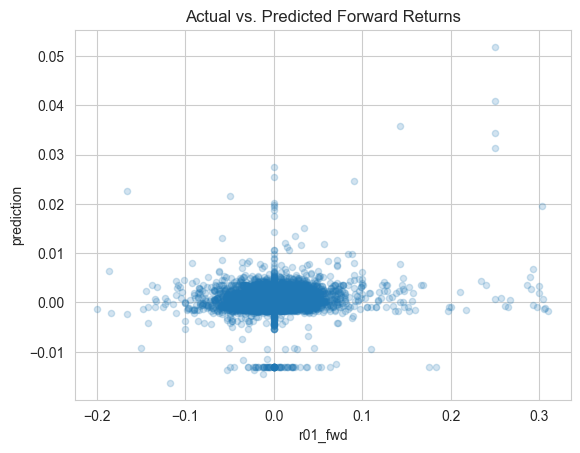

In [27]:
_ = eval_df.sample(10_000).plot.scatter(x="r01_fwd", y="prediction", alpha=0.2)
_ = plt.title("Actual vs. Predicted Forward Returns")

# Visualize Relationship Between Predicted vs Actual
Let's take a look if actual forward returns actually go in the same direction with predicted return.

In [51]:
eval_df["prediction_pct_rnk"] = eval_df.groupby("date")["prediction"].rank(pct=True)

In [60]:
eval_df["prediction_bin"] = pd.cut(eval_df["prediction_pct_rnk"], bins=np.arange(0, 1.1, .2), labels=False)

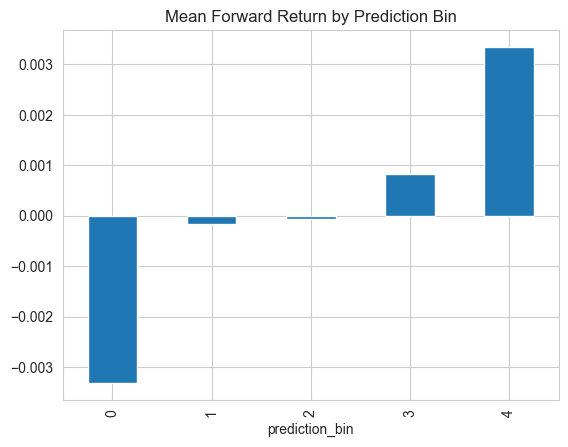

In [67]:
_ = eval_df.groupby("prediction_bin")["r01_fwd"].mean().plot(kind="bar")
_ = plt.title("Mean Forward Return by Prediction Bin")

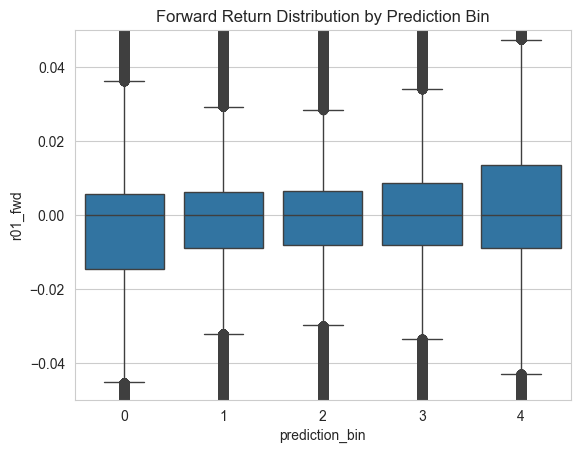

In [71]:
_ = sns.boxplot(data=eval_df, x="prediction_bin", y="r01_fwd")
_ = plt.ylim([-.05, .05])
_ = plt.title("Forward Return Distribution by Prediction Bin")

# Measure Profitability
Finally, we'll measure our model profitability if we were to use our model for buying and selling stocks daily based on the prediction. We'll also compare the profitability with return of SET index.

In [77]:
eval_df = eval_df.set_index(["symbol", "date"]).sort_index()

In [78]:
fwd_returns  = eval_df["r01_fwd"].unstack("symbol")
fwd_returns

symbol          24CS        2S     3BBIF         A        A5       AAI  \
date                                                                     
2020-12-28       NaN  0.014925       NaN -0.004000  0.000000       NaN   
2020-12-29       NaN  0.029412       NaN  0.004016  0.000000       NaN   
2020-12-30       NaN  0.004762       NaN  0.000000  0.000000       NaN   
2021-01-04       NaN -0.004739       NaN  0.000000  0.000000       NaN   
2021-01-05       NaN  0.009524       NaN  0.000000  0.000000       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-12-23  0.006944 -0.007299  0.000000  0.000000 -0.038168 -0.016393   
2024-12-24  0.000000 -0.007353  0.000000  0.000000  0.039683  0.033333   
2024-12-25 -0.006897  0.022222 -0.009434  0.000000  0.022901 -0.032258   
2024-12-26  0.027778  0.007246  0.009524  0.000000  0.014925  0.016667   
2024-12-27 -0.013514 -0.007194 -0.018868 -0.004065  0.036765  0.000000   

symbol           AAV       ABM      ACAP       ACC       ACE       ACG  \
date                                                                     
2020-12-28  0.016806 -0.012195  0.106667  0.018182  0.050562  0.028302   
2020-12-29 -0.024793  0.000000 -0.186747  0.000000 -0.026738 -0.009175   
2020-12-30  0.016949  0.012346 -0.029630  0.000000 -0.005495  0.027778   
2021-01-04  0.033333  0.036585 -0.045801  0.000000  0.044199  0.027027   
2021-01-05  0.000000 -0.011764 -0.056000 -0.017857  0.015873  0.026316   
...              ...       ...       ...       ...       ...       ...   
2024-12-23  0.000000  0.028037  0.000000  0.033898 -0.007752  0.011236   
2024-12-24  0.000000  0.009091  0.000000 -0.032787  0.023437 -0.011111   
2024-12-25 -0.007407 -0.027027  0.000000 -0.033898 -0.007634  0.000000   
2024-12-26  0.000000  0.000000  0.000000  0.017544  0.007692 -0.011236   
2024-12-27  0.029851 -0.009259  0.000000 -0.017241  0.038168  0.011364   

symbol           ADB       ADD    ADVANC        AE    AEONTS        AF  \
date                                                                     
2020-12-28  0.020619       NaN  0.008474  0.000000 -0.005000 -0.040334   
2020-12-29  0.000000       NaN -0.014005 -0.022727  0.020100  0.028986   
2020-12-30 -0.010100       NaN  0.000000  0.232558  0.054187  0.000000   
2021-01-04  0.010204       NaN  0.014204  0.018868 -0.042056 -0.014085   
2021-01-05  0.010102       NaN  0.005602 -0.018519 -0.048781  0.000000   
...              ...       ...       ...       ...       ...       ...   
2024-12-23  0.011236  0.066946  0.000000  0.000000  0.029412 -0.014286   
2024-12-24 -0.022222 -0.019608  0.007042  0.000000  0.016327  0.014493   
2024-12-25  0.000000  0.040000  0.003497  0.000000 -0.004016  0.000000   
2024-12-26  0.022727  0.009615  0.006969 -0.047619  0.012097  0.000000   
2024-12-27  0.022222  0.066667 -0.006920  0.050000  0.019920  0.000000   

symbol           AFC       AGE        AH       AHC        AI       AIE  \
date                                                                     
2020-12-28 -0.008403  0.005556  0.021978 -0.007042  0.005025  0.000000   
2020-12-29  0.000000 -0.033149 -0.043011  0.000000 -0.010000  0.000000   
2020-12-30  0.000000 -0.022857 -0.033708  0.000000 -0.005050 -0.025974   
2021-01-04  0.008475  0.017543  0.017442  0.007092  0.010152  0.026667   
2021-01-05  0.000000  0.000000  0.028571  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2024-12-23  0.004237  0.000000  0.080000  0.006579  0.000000 -0.009174   
2024-12-24  0.008439  0.024793  0.024691  0.000000  0.011299  0.018519   
2024-12-25 -0.004184  0.000000 -0.018072  0.006536  0.011173  0.000000   
2024-12-26  0.000000  0.008065  0.006135 -0.006493  0.016575  0.000000   
2024-12-27 -0.012605  0.000000 -0.006098  0.000000 -0.005435 -0.009091   

symbol         AIMCG    AIMIRT      AIRA       AIT        AJ       AJA  \
date                                                                     


In [79]:
predictions = eval_df["prediction"].unstack("symbol")
predictions

symbol          24CS        2S     3BBIF         A        A5       AAI  \
date                                                                     
2020-12-28       NaN  0.001634       NaN  0.001634  0.001634       NaN   
2020-12-29       NaN  0.001634       NaN  0.001698  0.001698       NaN   
2020-12-30       NaN  0.001634       NaN  0.001634  0.001634       NaN   
2021-01-04       NaN -0.001005       NaN -0.001005 -0.001005       NaN   
2021-01-05       NaN -0.000942       NaN -0.000942 -0.000942       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-12-23 -0.000906 -0.000841 -0.000492 -0.000841 -0.000906 -0.000906   
2024-12-24 -0.000746 -0.000519 -0.000616 -0.000841  0.000961  0.000310   
2024-12-25 -0.000680 -0.000189 -0.000427 -0.000491 -0.000746 -0.000906   
2024-12-26 -0.000680 -0.000906  0.000082 -0.000556 -0.000906  0.000660   
2024-12-27 -0.000906 -0.000746 -0.000682 -0.000189 -0.000906 -0.000906   

symbol           AAV       ABM      ACAP       ACC       ACE       ACG  \
date                                                                     
2020-12-28  0.001698  0.001634  0.001634  0.001698  0.001634  0.004481   
2020-12-29  0.001634  0.001698  0.001634  0.001634  0.001634  0.001819   
2020-12-30  0.001698  0.001634  0.015258  0.001634  0.001698  0.001819   
2021-01-04 -0.001005 -0.001005 -0.000942 -0.001005 -0.000942 -0.001005   
2021-01-05 -0.001005 -0.001005 -0.000942 -0.000942 -0.001005 -0.001005   
...              ...       ...       ...       ...       ...       ...   
2024-12-23 -0.000746  0.000508 -0.000777 -0.000746 -0.000841  0.000471   
2024-12-24 -0.000519 -0.000048 -0.000616 -0.000255 -0.000680 -0.000746   
2024-12-25 -0.000491 -0.000048 -0.000616  0.000310 -0.000906 -0.000330   
2024-12-26 -0.000491  0.000179 -0.000492  0.000310 -0.000680 -0.000255   
2024-12-27 -0.000841 -0.000189 -0.000126 -0.000746 -0.000746  0.000179   

symbol           ADB       ADD    ADVANC        AE    AEONTS        AF  \
date                                                                     
2020-12-28  0.001634       NaN  0.001634  0.001698  0.015258  0.001634   
2020-12-29  0.001634       NaN  0.001634  0.001698  0.001698  0.001698   
2020-12-30  0.001634       NaN  0.001634  0.001698  0.001634  0.001634   
2021-01-04 -0.000942       NaN -0.001005 -0.004180 -0.001005 -0.001005   
2021-01-05 -0.001005       NaN -0.001005 -0.001005 -0.000942 -0.000942   
...              ...       ...       ...       ...       ...       ...   
2024-12-23 -0.000048 -0.000906 -0.000906 -0.000841 -0.000491 -0.000906   
2024-12-24 -0.000906 -0.001570 -0.000841 -0.000519 -0.000906  0.000310   
2024-12-25  0.000471  0.000310 -0.000841 -0.000519 -0.000906 -0.000906   
2024-12-26 -0.000255 -0.000906 -0.000906 -0.000556 -0.000906 -0.000906   
2024-12-27 -0.000906 -0.000906 -0.000906  0.001168 -0.000906 -0.000841   

symbol           AFC       AGE        AH       AHC        AI       AIE  \
date                                                                     
2020-12-28  0.001634  0.001698  0.001698  0.001634  0.001634  0.001634   
2020-12-29  0.001698  0.001634  0.001634  0.001698  0.001634  0.001698   
2020-12-30  0.001634  0.001698  0.001698  0.001634  0.001634  0.001634   
2021-01-04 -0.001005 -0.000942 -0.000942 -0.001005 -0.000942 -0.000942   
2021-01-05 -0.001005 -0.001005 -0.001005 -0.001005 -0.001005 -0.001005   
...              ...       ...       ...       ...       ...       ...   
2024-12-23 -0.000841 -0.000491 -0.000906 -0.000680 -0.000841 -0.000841   
2024-12-24 -0.000841 -0.000189 -0.001814 -0.000746 -0.000519  0.000179   
2024-12-25 -0.000746 -0.000556 -0.000906 -0.000841 -0.000746 -0.000556   
2024-12-26 -0.000189 -0.000746 -0.000680 -0.000746 -0.000906 -0.000556   
2024-12-27 -0.000680 -0.000906 -0.000906 -0.000028 -0.000906 -0.000680   

symbol         AIMCG    AIMIRT      AIRA       AIT        AJ       AJA  \
date                                                                     


In [85]:
assert all(fwd_returns.index == predictions.index)
assert all(fwd_returns.columns == predictions.columns)

In [120]:
N_LONG = 50
N_SHORT = 50

long_signals = ((predictions
                .where(predictions > 0)
                .rank(axis=1, ascending=False) <= N_LONG)
                .astype(int))
short_signals = ((predictions
                  .where(predictions < 0)
                  .rank(axis=1) <= N_SHORT)
                 .astype(int))

In [121]:
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')

In [122]:
set_df = pd.read_csv("data/set_price_index.csv").set_index("Date")
set_return = set_df["Adj Close"].pct_change().to_frame("SET")

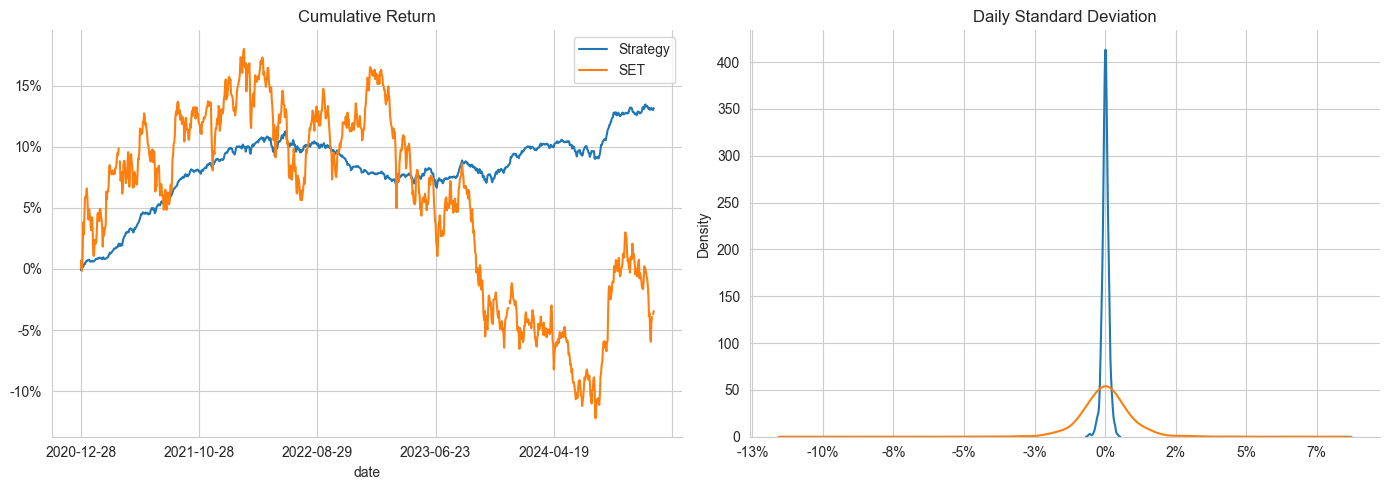

In [123]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(set_return).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(set_return, ax=axes[1], hist=False, label='SP500')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()

fig.tight_layout()